

---

# WSD par fine-tuning d'un modèle *BERT

On utilise ici les données du French FrameNet "ASFALDA": dans ces données, certains mots ont été associés à un frame FrameNet
- ces mots sont les "targets"
- **associer le bon frame à un target correspond à une tâche de WSD**
- modulo le fait qu'un même frame regroupe plusieurs entrées lexicales (par exemple FR_Commerce_buy => acheter.v, achat.n, acquérir.v, etc...)
- dans les données, les phrases contenant plusieurs targets ont été dupliquées: on a une ligne par couple phrase + target

Les données FrameNet comprennent également l'annotation des arguments sémantiques, et leur typage au moyen d'un rôle (Buyer, Seller, Goods ...), que l'on ignorera ici.

On va construire un classifieur :
- entrée = un target et sa phrase de contexte
- sortie = une distribution de probas sur les différents sens
  - ici les sens sont des frames
  - on peut ou pas contraindre que les sens "permis" pour un target soient uniquement ceux vus à l'entraîînement pour ce target (pour ce lemme)

On utilisera un modèle *BERT pour obtenir une représentation contextuelle du mot target.

Mais BERT donne des vecteurs contextuels pour chaque **token**, un token pouvant être un sous-mot.
**Dans la version de base, vous utiliserez le vecteur *BERT du premier token du mot target.**

Ainsi pour le target *comprenions* dans:

*Nous comprenions bien le cours*

tokenisé en :

'\<s>', 'Nous\</w>', 'compren', 'ions\</w>', 'bien\</w>', 'le\</w>', 'cours\</w>', '.\</w>, '\</s>'

vous utiliserez le vecteur caché du sous-mot "compren".

Le classifieur dans la version de base sera un réseau de neurones constitué
- d'un réseau *BERT
- dont on récupère le vecteur caché du 1er sous-mot du target
- et une couche linéaire + softmax sur les différents frames présents dans les données d'entraînement.

Le classifieur est unique pour tous les lemmes, et peut prédire tout sens(frame) pour tout lemme target, même s'il s'agit d'un sens non vu pour ce lemme dans les données d'apprentissage.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from tqdm import tqdm  
from tqdm.notebook import tqdm # for progress bars in notebooks
from random import shuffle
import os


## Conventions de nommage des variables

- on considère des phrases déjà segmentées en mots (avec segmenteur par règles)
- (mais pas encore segmentées en sous-mots)
- on utilise "word" ou "w" pour un mot (ou ponctuation)
- et "token" après tokenisation de type *BERT (BPE ou WordPiece etc...)

- on distingue dans les noms de variables 
 - les identifiants entiers des symboles 
   (pour le vocabulaire des tokens, le vocabulaire des labels ...)
 - versus le rang d'un élément (token ou mot) dans une séquence
- tid => id de token
- trk / wrk => rang de token / rang de mot dans une séquence
- tg => "target", donc 
 - tg_wrk = le rang dans la phrase du mot target
 - tg_trk = le rang dans la tokenisation *BERT du premier token du mot target


## Les données "ASFALDA"

---



Il s'agit des données d'un FrameNet du français, comprenant environ 16000 annotations, pour environ 100 frames distincts.


### Récupération des données

> Indented block



### Lecture des données

In [ ]:
# lecture des données

def load_asfalda_data(gold_data_file, split_info_file, val_proportion=None):
    """
        Inputs: - asfalda gold data file
                - file with list of sentid / corpus type pairs (corpus types train/dev/test)
                - val_proportion : if set to value > 0 (and <1)
                  the training file is split into train/validation
                  so that the validation part represents the provided proportion 
                  of the original training file
        Returns 3 dictionaries (whose keys are corpus types (train/dev/test/val))
        - sentences
        - rank of target word in each sentence
        - gold labels

        Example:
        sentences['train'] = [['Le', 'code', 'comprend', 'des', 'erreurs','.'],
                              ['Comprends', '-tu', '?']]
         # the targets are are the 3rd and first words                     
        tg_wrks['train'] = [2, 0]
        tg_lemmas['train'] = ['comprendre', 'comprendre']
        labels = ['frame1', 'frame2']
                                
    """
    # chargement de la répartition usuelle des phrases en train / dev / test
    s = open(split_info_file)
    lines = [ l[:-1].split('\t') for l in s.readlines() ]
    split_info_dic = { line[0]:line[1] for line in lines }

    # les phrases de dev / train / test
    sentences = {'dev':[], 'train':[], 'test':[]}
    # les word rank (wrk) des mots étiquetés en frames (les "targets" ou "tg")
    tg_wrks = {'dev':[], 'train':[], 'test':[]}
    # les lemmes des targets
    tg_lemmas = {'dev':[], 'train':[], 'test':[]}
    # les sens (= des frames) étiquetés pour ces mots
    labels = {'dev':[], 'train':[], 'test':[]}

    max_sent_len = {'dev':0, 'train':0, 'test':0}
    max_tg_wrk = {'dev':0, 'train':0, 'test':0}

    stream = open(gold_data_file)
    for line in stream.readlines():
        if line.startswith('#'):
            continue
        line = line.strip()
        (sentid, tg_wrk, frame_name, tg_lemma, tg_pos, rest) = line.split('\t',5)
        # on ignore pour l'instant l'annotation en rôles
        # les phrases sont pré-segmentées en mots (séparateur = espace) 
        # => on splitte, de manière à utiliser infra le tokenizer en mode is_split_into_words=True
        sentence = rest.split("\t")[-1].split(' ')
        part = split_info_dic[sentid]
        tg_wrk = int(tg_wrk)

        l = len(sentence)
        sentences[part].append(sentence)
        labels[part].append(frame_name)
        tg_wrks[part].append(tg_wrk)
        tg_lemmas[part].append(tg_lemma)
        if max_sent_len[part] < l: 
            max_sent_len[part] = l 
        if max_tg_wrk[part] < tg_wrk: 
            max_tg_wrk[part] = tg_wrk 
    print("Longueur max des phrases:", max_sent_len)
    print("Rang max du target (en mots):", max_tg_wrk)
    
    # decoupage du train en train + validation
    # (pour réglage du nombre d'époques)
    if val_proportion:
        # le split sera le même pour les 3 listes
        for dic in [sentences, tg_wrks, labels, tg_lemmas]:
            (dic['val'], dic['train']) = split_list(dic['train'], proportion=val_proportion)
    return sentences, tg_wrks, tg_lemmas, labels

def split_list(inlist, proportion=0.1, shuffle=False):
     """ partitions the input list of items (of any kind) into 2 lists, 
     the first one representing @proportion of the whole 
     
     If shuffle is not set, the partition takes one item every xxx items
     otherwise, the split is random"""
     n = len(inlist)
     size1 = int(n * proportion)
     if not(size1):
          size1 = 1
     print("SPLIT %d items into %d and %d" % (n, n-size1, size1))
     # if shuffle : simply shuffle and return slices
     if shuffle:
          # shuffle inlist (without changing the original external list
          # use of random.sample instead of random.shuffle
          inlist = sample(inlist, n)
          return (inlist[:size1], inlist[size1:])
     # otherwise, return validation set as one out of xxx items
     else:
          divisor = int(n / size1)
          l1 = []
          l2 = []
          for (i,x) in enumerate(inlist):
               if i % divisor or len(l1) >= size1:
                    l2.append(x)
               else:
                    l1.append(x)
          return (l1,l2)


In [ ]:
gold_data_file = './asfalda_data_for_wsd/sequoiaftb.asfalda_1_3.gold.uniq.nofullant.txt'
# les informations pour le split train / dev / test
# tel qu'utilisé généralement pour ce corpus
split_info_file = './asfalda_data_for_wsd/sequoiaftb_split_info'

sentences, tg_wrks, tg_lemmas, label_strs = load_asfalda_data(gold_data_file,
                                                              split_info_file, 
                                                              val_proportion=0.1)

# récupération de tous les labels (= les frames) rencontrés
all_labels_strs = []
all_lemma_strs = []
for p in sentences.keys():
    all_labels_strs += label_strs[p]
    all_lemma_strs += tg_lemmas[p]
    avgl = sum([len(s) for s in sentences[p]])/len(sentences[p])
    print("%s : %d sentences, average lentgh=%3.2f" 
          %(p, len(sentences[p]), avgl))

#@@ ATTENTION: ici vous codez tous les lemmes, y compris les lemmes du dev / test inconnus du train
#   => cela donne une surestimation des performances utilisant les lemmes
i2lemma = list(set(all_lemma_strs))
lemma2i = {x:i for i,x in enumerate(i2lemma)}


# id des labels (i.e. ici des frames)
i2label = list(set(all_labels_strs))
label2i = {x:i for i,x in enumerate(i2label)}
# l'id du frame spécial "Other_sense"
i_OTHER_SENSE = label2i['Other_sense']

# séquence des ids de labels gold 
# pour chaque sous-corpus (clé = partie de corpus dev/train/test/val)
labels = {}
for p in label_strs.keys():
    labels[p] = [label2i[x] for x in label_strs[p]]




Longueur max des phrases: {'dev': 115, 'train': 271, 'test': 140}
Rang max du target (en mots): {'dev': 96, 'train': 267, 'test': 115}
SPLIT 18657 items into 16792 and 1865
SPLIT 18657 items into 16792 and 1865
SPLIT 18657 items into 16792 and 1865
SPLIT 18657 items into 16792 and 1865
dev : 2688 sentences, average lentgh=38.03
train : 16792 sentences, average lentgh=38.99
test : 3447 sentences, average lentgh=38.45
val : 1865 sentences, average lentgh=38.97


In [ ]:
i_OTHER_SENSE

86

### Baseline MFS ("most frequent sense")

In [ ]:
# TODO:
# calculer le sens le plus fréquent de chaque lemme-target
# (le plus fréquent dans train+val)

# et calculez la baseline MFS ("most frequent sense")
# - sur le train+val
# - sur le dev

# TODO:
# Etudiez les éléments de dev qui sont "inconnus" de train+val:
# - les lemmes-target inconnus
# - les frames inconnus
# - les associations frame / lemme-target inconnus
from collections import defaultdict
def frequence(tg_lemmas,label_strs):
  dict_lemmes = defaultdict(lambda: defaultdict(int))
  dict_most_frequent = {}
  for lemme, sens in zip(tg_lemmas,label_strs):
      dict_lemmes[lemme][sens]+=1
  for key, value in dict_lemmes.items():
    max_item = max(value, key=lambda k: value[k])
    dict_most_frequent[key] = max_item
  return dict_lemmes, dict_most_frequent


dict_lemmes_train, dict_most_frequent_train = frequence(tg_lemmas['train']+tg_lemmas['val'],label_strs['train']+label_strs['val'])
dict_lemmes_val, dict_most_frequent_val = frequence(tg_lemmas['val'],label_strs['val'])
dict_lemmes_dev, dict_most_frequent_dev = frequence(tg_lemmas['dev'],label_strs['dev'])


In [ ]:
def baseline(dict_most_frequent, tg_lemmas,label_strs,train_or_dev = 'train+val'):
  amount_correct = 0
  for lemme, sens in zip(tg_lemmas,label_strs):
    if sens == dict_most_frequent[lemme]:
      amount_correct +=1
  return 'Accuracy of baseline model on ' + train_or_dev + ' is:',amount_correct/len(tg_lemmas)*100


In [ ]:
baseline(dict_most_frequent_train, tg_lemmas['train']+tg_lemmas['val'],label_strs['train']+label_strs['val'])

('Accuracy of baseline model on train+val is:', 81.39572278501367)

In [ ]:
baseline(dict_most_frequent_dev, tg_lemmas['dev'],label_strs['dev'], 'dev')

('Accuracy of baseline model on dev is:', 83.59375)

Now we need to find the lemmas, targets and the pairs of target + lemma that are not in train+val sets but are present in dev set.

In [ ]:
from itertools import chain

lemmes_inconnus = []
sens_inconnus = []

for lemma in tg_lemmas['dev']:
  if lemma not in chain(tg_lemmas['train'], tg_lemmas['val']):
    lemmes_inconnus.append(lemma)
for sens in label_strs['dev']:
  if sens not in chain(label_strs['train'], label_strs['val']):
    sens_inconnus.append(sens)



In [ ]:
'The number of unknown lemmas in dev is', len(set(lemmes_inconnus))

('The number of unknown lemmas in dev is', 20)

In [ ]:
'The number of unknown sens in dev is', len(set(sens_inconnus))

('The number of unknown sens in dev is', 0)

In [ ]:
unknown_associations = []
for lemma in dict_lemmes_dev.keys():
  if lemma in dict_lemmes_train:
    associations_possibles_train = dict_lemmes_train[lemma].keys()
    associations_possibles_val = dict_lemmes_dev[lemma].keys()
    for association_val in associations_possibles_val:
      if association_val not in associations_possibles_train:
         unknown_associations.append((lemma,association_val))




In [ ]:
'The number of unknown associations in dev is', len(set(unknown_associations))

('The number of unknown associations in dev is', 22)

In [ ]:
dict_most_frequent_train

## Modèle et tokenization de type *BERT

On va utiliser un modèle pré-entraîné de type *BERT, en passant par le module "transformers" d'huggingface.

In [ ]:
try:
  import transformers
except ImportError:
  !pip install transformers
  
# les modules permettant de charger un modèle (resp. un tokenizer / une config)
# et de repérer le type d'instance automatiquement d'après le nom du modèle
from transformers import AutoModel, AutoTokenizer, AutoConfig

     |████████████████████████████████| 1.8MB 11.9MB/s 
     |████████████████████████████████| 2.9MB 40.4MB/s 
     |████████████████████████████████| 890kB 39.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=ab5ccea4f6fff3cec4b083f9cf7de5a9af7cbd36004dcbb0891dad9f513827f4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
# On choisit de travailler avec le modèle FlauBERT
# cf. liste des modèles dispos : https://huggingface.co/transformers/pretrained_models.html

# on charge ici le tokenizer Flaubert
# et la config du modèle
flaubert_tokenizer = AutoTokenizer.from_pretrained("flaubert/flaubert_base_cased")
flaubert_config = AutoConfig.from_pretrained("flaubert/flaubert_base_cased")

### Encodage des données (correspondance entre rang de mot et rang de token 




Pour pouvoir utiliser un modèle *BERT pré-entraîné, il faut
- utiliser la même tokenisation en tokens (potentiellement des sous-mots) que celle utilisée à l'entraînement du modèle
- convertir les séquences de tokens en séquences d'ids de tokens 
- et maintenir un lien entre les rangs de mot dans la phrase (dont le rang du target) et les rangs de tokens

In [ ]:
from nltk.tokenize import WordPunctTokenizer
class WSDEncoder:
    def __init__(self, tokenizer, config):
        self.tokenizer = tokenizer
        self.config = config # pour récupérer les indices des tokens spéciaux
    
    def new_ranks(self, sentences, tg_works):

      tg_trks = []
      phrases = []
      

      for sent, rank in zip(sentences, tg_works):
        has_seen = False
       
        word_gold = sent[rank]
        phrase = []
        for index, word in enumerate(sent):
          if word == word_gold and has_seen == False:
            tg_trks.append(len(phrase)+1)#+1 Because of the eventual 'beginning of sentence' token
            has_seen = True
          phrase.extend(flaubert_tokenizer.tokenize(word))
        phrases.append(phrase)
      
      return phrases, tg_trks
 
    
    def encode(self, sentences, tg_wrks, max_length=350, verbose=False, is_split_into_words=True):
      """ 
      Input: 
        - sentences : list of sentences
           -- if is_split_into_words:
              sentences are already split into words 
              (hence sentences = list of word strings [[w1, w2, w3], [w1, w2]...])
           -- otherwise, sentences are to split on spaces to get words

        - tg_wrks : list of the ranks of target words
          (one rank per sentence, starting at 0 in a sentence)
        - max_length : maximum length in number of tokens

      Returns:
        - tid_seqs : the sentences padded/truncated so that each contains max_length token ids
        - first_trk_of_targets : for each sentence, 
                                 the rank in corresponding tid_seq
                                 of the first token of the target word
      Example
      sentences = ['Conséquemment , nous comprendrions .']
      tg_wrks = [3]

      if the sentence is tokenized into 
        '<s>', 'Con', 'séqu', 'emment</w>', ',</w>', 'nous</w>', 'compr', 'end', 'rions</w>', '.</w>' ....
      the first token rank of the target "comprendrions" is 6 ('compr')

      """
      if is_split_into_words == False:
        sentences = [sentence.split() for sentence in sentences] #Splitting sentences on spaces
      
     

      phrases, first_trk_of_targets = self.new_ranks(sentences, tg_wrks)
      
      
      tokenized = []
   
      for phrase in phrases:
         tokenized.append(flaubert_tokenizer.encode(phrase,add_special_tokens = True,truncation = True, max_length = max_length, padding = 'max_length', pad_to_max_length = True))
     
      #Encoding lemmas

      
      # TODO HERE : encoding method

      # Indications:
      # 1. apply flaubert tokenization word per word, and build
      #    tid_seqs first without padding / truncation nor special tokens,
      #    and keep track of token rank of first token of target word
      # 2. then truncate and pad, and add special symbols
      # (write several methods for easier reading)
      
      return tokenized, first_trk_of_targets

encoder = WSDEncoder(flaubert_tokenizer, flaubert_config)

# test encoder
test_sents = ["Conséquemment leurs codes comprendraient des erreurs .",
            "J' essaie de comprendre les transformers .",  
            "Il n' a pas bien compris le code !"]
# les mots target sont les occurrences de du verbe "comprendre"
test_tg_wrks = [3, 3, 5] # En réalité pour la première phrase comprendraient se situe au troisième

# TODO: décommenter pour tester votre méthode encode

# 1. Not add padding and not add special tokens

print("Not add padding and not add special tokens : ")
tid_seqs, first_trk_of_targets = encoder.encode(test_sents, test_tg_wrks, max_length=100,is_split_into_words=False)
#print(len(tid_seqs)," ",len(first_trk_of_targets))
for tid_seq, ft in zip(tid_seqs, first_trk_of_targets):
    print("Len = %d target token rank = %d tid_seq = %s" % (len(tid_seq), ft, str(tid_seq))) 

Not add padding and not add special tokens : 
Len = 100 target token rank = 6 tid_seq = [0, 1198, 17358, 13299, 121, 5677, 18719, 16724, 23, 3842, 16, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Len = 100 target token rank = 4 tid_seq = [0, 158, 5213, 15, 965, 22, 14659, 896, 16, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Len = 100 target token rank = 6 tid_seq = [0, 59, 51, 34, 42, 83, 681, 20, 1138, 82, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

#### Test encodage

In [ ]:
encoder = WSDEncoder(flaubert_tokenizer, flaubert_config)

# test encoder

#@@ erreur dans le test
#test_sents = ["Conséquemment", "leurs", "codes", "comprendraient", "des", "erreurs", "."]
test_sents = [["Conséquemment", "leurs", "codes", "comprendraient", "des", "erreurs", "."]]
                    
# les mots target sont les occurrences de du verbe "comprendre"
#test_tg_wrks = [2]
test_tg_wrks = [3]

# TODO: décommenter pour tester votre méthode encode
tid_seqs, first_trk_of_targets = encoder.encode(test_sents, test_tg_wrks, max_length=20, verbose=True, is_split_into_words = True)

print('trgs',first_trk_of_targets)

for tid_seq, ft in zip(tid_seqs, first_trk_of_targets):
  #@@ plus de traces
  print(flaubert_tokenizer.convert_ids_to_tokens(tid_seq))
  print("Len = %d target token rank = %d tid_seq = %s" % (len(tid_seq), ft, str(tid_seq)))



trgs [6]
['<s>', 'Con', 'séqu', 'emment</w>', 'leurs</w>', 'codes</w>', 'compr', 'endraient</w>', 'des</w>', 'erreurs</w>', '.</w>', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
Len = 20 target token rank = 6 tid_seq = [0, 1198, 17358, 13299, 121, 5677, 18719, 16724, 23, 3842, 16, 1, 2, 2, 2, 2, 2, 2, 2, 2]


In [ ]:
encoder.tokenizer.convert_ids_to_tokens(6000)

'autorisé</w>'

### Classe WSDData: encodage complet des données asfalda

In [ ]:
import random
class WSDData:
    def __init__(self, corpus_type, sentences, tg_wrks, tg_lemmas, labels, encoder, max_length=350):
        """
        Inputs:
        - corpus type string (train/dev/test/val)
        - list of sentences (each sentence = list of word strings)
        - list of target word ranks : one per sentence
        - list of gold label id
        - encoder = instance of WSDEncoder

        - max_length = size of encoded sequences, in nb of bert tokens 
                      (padded / truncated via encoder.encode)
    
        Encodes all the data using the relevant identifiers
        """
        
        self.corpus_type = corpus_type # train / dev / test / val
        self.size = len(sentences)
        self.encoder = encoder

        self.labels = labels       # gold label ids
        self.sentences = sentences # list of list of word strings
        self.tg_lemmas = tg_lemmas #list of target lemmas
        
        tid_seqs, first_trk_of_targets = encoder.encode(sentences, tg_wrks, max_length)
        self.tg_lemma_indexes = [lemma2i[lemma]for lemma in self.tg_lemmas]

        self.tid_seqs = tid_seqs  # sequences of token ids
        self.first_trk_of_targets  = first_trk_of_targets   # target token ranks
        
        

    def shuffle(self):
      """
      Rearranges all the data in a new random order
      (sentences, tg_lemmas, tg_trks, tid_seqs, labels)

      NB: ** original order is lost **
      """
      z = list(zip(self.labels, self.sentences, self.tg_lemma_indexes, self.tid_seqs, self.first_trk_of_targets))
      random.shuffle(z)
      labels, sentences, tg_lemma_indexes, tid_seqs,first_trk_of_targets = zip(*z)
      

      
      return labels, sentences, tg_lemma_indexes, tid_seqs,first_trk_of_targets

 

    # production de batches de données
    def make_batches(self, batch_size, shuffle_data=False):
        """
        Returns an iterator over 3 torch tensors 
        - batch of token id sequences
        - corresponding batch of target token ranks
        - corresponding batch of labels for these targets
        """
        # TODO
        # (use "yield" function to return iterator
        bstart = 0
        if shuffle_data:
          self.labels, self.sentences, self.tg_lemmas, self.tid_seqs, self.first_trk_of_targets = self.shuffle()
        N = len(self.labels)
        while bstart < len(self.labels):
          bend = min(bstart+batch_size,N)
          b_labels, b_tid_seqs, b_tg_trks, b_lemmas = self.labels[bstart:bend] , self.tid_seqs[bstart:bend] , self.first_trk_of_targets[bstart:bend], self.tg_lemma_indexes[bstart:bend] 
          assert(len(b_labels)==len(b_tid_seqs))
          yield (b_tid_seqs, b_tg_trks, b_labels, b_lemmas)#lemmas
        
          bstart += batch_size

       
        







In [ ]:
sentences.keys()

dict_keys(['dev', 'train', 'test', 'val'])

In [ ]:
MAX_LENGTH = 300
wsd_data = {}
# key = part of the split corpus (train/test/dev/val)
for p in sentences.keys():
    print("Encodage de la partie %s ..." % p)
    wsd_data[p] = WSDData(p, sentences[p], tg_wrks[p], tg_lemmas[p], labels[p], 
                          encoder, max_length=MAX_LENGTH)
    # vérif que l'encodage donne bien la bonne taille
    for i, s in enumerate(wsd_data[p].tid_seqs):
        if len(s) != MAX_LENGTH:
            print("Size bug:", i, s)

Encodage de la partie dev ...
Encodage de la partie train ...
Encodage de la partie test ...
Encodage de la partie val ...


## Classe WSDClassifier : le réseau de neurones pour la WSD

Architecture de base = 
- le modèle *BERT (ici FlauBERT)
- puis une couche linéaire + softmax

### Le réseau : architecture, propagation avant, évaluation

In [ ]:
class MLP(nn.Module):
  def __init__(self,input_size,output_size,hidden_size):
    super(MLP, self).__init__()
    self.encoder = nn.Linear(input_size,hidden_size)
    self.decoder = nn.Linear(hidden_size,output_size)
    self.activation = nn.Tanh()
  def forward(self,xinput):
    h = self.activation(self.encoder(xinput))
    return self.decoder(h)




In [ ]:

class WSDClassifier(nn.Module):

    def __init__(self, num_labels, device='cpu', bert_model_name="flaubert/flaubert_base_cased", freeze_bert = True, use_mlp = False, hidden_size = 100,nbr_lemmas = len(lemma2i), lemma_embedding_size = 518, add_lemmas = False):
        super(WSDClassifier, self).__init__()

        self.device = device
        self.use_mlp = use_mlp
        self.add_lemmas = add_lemmas
                
        # le début du réseau est un réseau de type *BERT
        # le .to(device) déclenche la copie vers un éventuel GPU
        self.bert_layer = AutoModel.from_pretrained(bert_model_name,
                                                   ).to(self.device)
        # on récupère la config pour avoir la taille des embeddings bert
        self.bert_config = AutoConfig.from_pretrained(bert_model_name)
        
        if self.add_lemmas:
          #Adding lemma information
          self.hidden_size_bert = int(self.bert_config.hidden_size)+int(lemma_embedding_size)
          print('lemmahidden', self.hidden_size_bert)
        else:
          self.hidden_size_bert = int(self.bert_config.hidden_size)
        if add_lemmas:
          self.lemma_embedding = nn.Embedding(nbr_lemmas, lemma_embedding_size).to(self.device)
        
        #print('hidden',hidden_size)
        # TODO HERE : la suite
        # TODO: implement option freeze_bert
        if freeze_bert:
          for param in self.bert_layer.parameters(): #Freezing the Bert parameters
            param.requires_grad = False
        if self.use_mlp:
          self.mlp = MLP(self.hidden_size_bert,num_labels,100).to(self.device)

        else:
          self.linear = torch.nn.Linear(self.hidden_size_bert,num_labels).to(self.device)
        self.softmax = torch.nn.LogSoftmax(dim = 1).to(self.device)
        
        

    def forward(self, b_tid_seq, b_tg_trk, b_tg_lemma_indexes = None):
        """
        Inputs: (all are tensors, on the relevant device)
            - a batch of sentences = a batch of token id sequences 
              (as output in 'input_ids' member of tokenizer output)
            - a batch of target token rank = for each of the sentences, 
              the rank of first token of the target word to disambiguate

        Output: log_softmax scores for the whole batch (batch_size x num_labels)
        """
        """
        self.main_part = torch.nn.Sequential(
            self.bert_layer,
            self.linear,
            self.softmax)
        """
        
     
    
        embeddings_bert = self.bert_layer(b_tid_seq, return_dict = True).last_hidden_state.to(self.device)
        
       
      
     
      
        
        embeddings_bert_tgt = embeddings_bert[torch.arange(embeddings_bert.size(0)), b_tg_trk].to(self.device) #last hidden state, ranks. We extract the 
        #necessary contextualised embeddings from the last layer
        
        if self.add_lemmas: #add lemma information
          lemma_embeddings = self.lemma_embedding(b_tg_lemma_indexes).to(self.device)
          embeddings_bert_tgt = torch.cat((embeddings_bert_tgt,lemma_embeddings), dim = 1).to(self.device)#If we use lemmas, we concat bert embeddings and information about lemmas
        

        
        if self.use_mlp:
          linear_tgt = self.mlp(embeddings_bert_tgt).to(self.device)
        else:
          linear_tgt = self.linear(embeddings_bert_tgt).to(self.device)
        
        soft_tgt = self.softmax(linear_tgt).to(self.device)
       
        
        return soft_tgt
        #idx = torch.tensor([1, 2])
        #x[torch.arange(x.size(0)), idx]
     
        
        # TODO HERE
        #  - récuperer les embeddings *bert de tous les tokens des phrases du batch 
        #    [ batch_size * seq_len * bert_emb_size ]
        #
        #  - isoler l'embedding du token target pour toutes les phrases du batch
        #    [ batch_size * bert_emb_size ]

        #
        #    Indications pour le faire élégamment et efficacement:
        #    https://discuss.pytorch.org/t/how-to-select-specific-vector-in-3d-tensor-beautifully/37724
        #
        #  - et suite pour fine tuning
            
    def run_on_dataset(self, wsd_data, optimizer, batch_size=32, validation_use = False):
        """
        Run classifier on wsd_data and compute accuracy
        Inputs = 
         - wsd_data (WSDDataset instance)
         - batch_size
        Returns:
         - list of predicted label ids
        """
        pred_labels = []
        val_losses = []
        batch_acc = []
        
        loss_function = nn.NLLLoss()


        
        # toggle evaluation mode of the model (IMPORTANT)
        self.eval()
        for b_tid_seqs, b_tg_trks, b_labels, b_lemma_idx in wsd_data.make_batches(32, shuffle_data=False):
          with torch.no_grad():
            b_tid_seqs = torch.tensor(b_tid_seqs, device=self.device).to(self.device)
            
            b_tg_trks = torch.tensor(b_tg_trks, device=self.device).to(self.device)
            b_labels = torch.tensor(b_labels, device=self.device).to(self.device)
            b_lemma_idx = torch.tensor(b_lemma_idx, device=self.device).to(self.device)
            log_probs = classifier(b_tid_seqs, b_tg_trks, b_lemma_idx).to(self.device)
        
            log_probs = self(b_tid_seqs, b_tg_trks,b_lemma_idx)
            b_pred_labels = torch.argmax(log_probs, dim=1).to(self.device)
            
            pred_labels.extend(b_pred_labels)
            
            if validation_use:
            
              loss = loss_function(log_probs,b_labels)
    
              val_losses.append(loss.item())
          
          batch_acc.append(self.evaluate(b_labels,b_pred_labels))
          


        
     
        return pred_labels, val_losses, mean(batch_acc), b_labels, batch_acc

    def evaluate(self, gold_labels, pred_labels):
        """ returns accuracy, nb_correct, nb_total """
        
        acc = float(torch.sum(gold_labels == pred_labels))/len(gold_labels)
        return acc

        # TODO 


        


In [ ]:
# une instance de WSDClassifier
num_labels = len(i2label)
classifier = WSDClassifier(num_labels, device = 'cuda')

#en décommentant, on voit le nb impressionnant de paramètres du modèle *BERT ...
for name, param in classifier.named_parameters():
  print("PARAM named %s, of shape %s" % (name, str(param.shape)))
  print(param.requires_grad)
    


PARAM named bert_layer.position_embeddings.weight, of shape torch.Size([512, 768])
False
PARAM named bert_layer.embeddings.weight, of shape torch.Size([68729, 768])
False
PARAM named bert_layer.layer_norm_emb.weight, of shape torch.Size([768])
False
PARAM named bert_layer.layer_norm_emb.bias, of shape torch.Size([768])
False
PARAM named bert_layer.attentions.0.q_lin.weight, of shape torch.Size([768, 768])
False
PARAM named bert_layer.attentions.0.q_lin.bias, of shape torch.Size([768])
False
PARAM named bert_layer.attentions.0.k_lin.weight, of shape torch.Size([768, 768])
False
PARAM named bert_layer.attentions.0.k_lin.bias, of shape torch.Size([768])
False
PARAM named bert_layer.attentions.0.v_lin.weight, of shape torch.Size([768, 768])
False
PARAM named bert_layer.attentions.0.v_lin.bias, of shape torch.Size([768])
False
PARAM named bert_layer.attentions.0.out_lin.weight, of shape torch.Size([768, 768])
False
PARAM named bert_layer.attentions.0.out_lin.bias, of shape torch.Size([768])

#### Test de la propagation avant

In [ ]:


# inutile de calculer les gradients
with torch.no_grad():
    # mode evaluation et pas train
    classifier.eval()
    for b_tid_seqs, b_tg_trks, b_labels, _ in wsd_data['dev'].make_batches(32, shuffle_data=True):
        b_tid_seqs = torch.tensor(b_tid_seqs, device=classifier.device)
        b_tg_trks = torch.tensor(b_tg_trks, device=classifier.device)
        b_labels = torch.tensor(b_labels, device=classifier.device).to(classifier.device)
        print('input size : ',b_tid_seqs.size()," reference size : ",b_tg_trks.size())
        log_probs = classifier(b_tid_seqs, b_tg_trks)
        print('output size : ',log_probs.size()," reference size : ",b_labels.size())
       
        gold = b_labels[0] #.item()
        print("GOLD LABEL of first ex %d ( = %s)" % (gold, i2label[gold]))
        print("LOG_PROBS before training: %s\n\n" % str(log_probs[0]))
        break
        

        



input size :  torch.Size([32, 300])  reference size :  torch.Size([32])
output size :  torch.Size([32, 106])  reference size :  torch.Size([32])
GOLD LABEL of first ex 45 ( = Commerce_sell)
LOG_PROBS before training: tensor([-3.7284, -5.1197, -4.1884, -7.6664, -4.8634, -3.9092, -4.8207, -4.5038,
        -5.1712, -5.3768, -6.0964, -4.6506, -5.2555, -3.7594, -4.2031, -6.1007,
        -5.6158, -4.3698, -3.7725, -5.3429, -6.9869, -3.9009, -3.5555, -6.3361,
        -3.5417, -4.2966, -5.3058, -4.4760, -4.7242, -5.2146, -5.0569, -5.2539,
        -6.7907, -4.5246, -5.0665, -5.1983, -6.0098, -5.5797, -5.3340, -6.2512,
        -4.1346, -5.0070, -4.1355, -3.5273, -6.0361, -7.1871, -5.2185, -4.0830,
        -5.9350, -7.8612, -4.7678, -4.5445, -4.5384, -4.9718, -5.1677, -6.4736,
        -3.2220, -6.1443, -5.7149, -5.5913, -4.3186, -3.5974, -6.0416, -6.6388,
        -4.8633, -6.9739, -5.8651, -4.6429, -3.7798, -5.2011, -3.0197, -5.0672,
        -3.8935, -4.4543, -5.4348, -4.5266, -6.9515, -3.9264, -

In [ ]:
import numpy as np
np.array(wsd_data['train'].labels).shape

(16792,)

In [ ]:
np.array(list(label2i.values()))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105])

### Entraînement : fine-tuning sur la tâche de WSD

In [ ]:
# training
from statistics import mean
import numpy as np

BATCH_SIZE = 32
LR = 0.0005
n_epochs = 20
import numpy as np
stop_early = 0
early_stopping_patience = 6


#loss_function = nn.CrossEntropyLoss()
loss_function = nn.NLLLoss() 
#optimizer = optim.SGD(classifier.parameters(), lr=LR)
optimizer = optim.Adam(classifier.parameters(), lr=LR)

config_name = 'sequoiaftb.asfalda_1_3.wsd.lr' + 'Adam' + str(LR) + '_bs' + str(BATCH_SIZE)
out_model_file = './' + config_name + '.model'
out_log_file = './' + config_name + '.log'


# perte à chaque époque (sur le train / sur le validation set)
train_losses = []
val_losses = []
val_accs = []
min_val_loss = None
epoch_losses = []
# pour tests: utiliser training sur dev
#train_data = data['dev'] # data['train']
train_data = wsd_data['train']
val_data = wsd_data['val']
dev_data = wsd_data['dev']
classifier.train()
early_stopping_patience = 0 #how many times dev accuracy might be smaller than previous time
stop_early = 6

print('Training.....')
acc = 0
for epoch in range(n_epochs):  # loop over the dataset multiple times
  classifier.train()
  
  print('Training..... epoch nr: ', epoch)
  for b_tid_seqs, b_tg_trks, b_labels, _ in train_data.make_batches(64, shuffle_data=True):
    
  
    optimizer.zero_grad()
    b_tid_seqs = torch.tensor(b_tid_seqs, device=classifier.device).to(classifier.device)
    b_tg_trks = torch.tensor(b_tg_trks, device=classifier.device).to(classifier.device)
    b_labels = torch.tensor(b_labels, device=classifier.device).to(classifier.device)
    log_probs = classifier(b_tid_seqs, b_tg_trks).to(classifier.device)
  
    loss = loss_function(log_probs,  b_labels)
    
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
  epoch_losses.append(sum(train_losses)/len(train_losses))
  
  pred_labels, val_losses, val_acc, _, _ = classifier.run_on_dataset(val_data, optimizer, batch_size=32, validation_use=True)
  print('--------')
  print('train loss: ',epoch_losses[-1],'val accuracy: ', val_acc)
  print('--------')
  if val_acc>=acc:
    acc=val_acc
  else:
    early_stopping_patience +=1
    if early_stopping_patience == stop_early:
      print('Stopping early...')
      break

  
    
  
 


        
  
           
# TODO HERE
# training
# - basic : train for NB_EPOCHS +
# - BONUS : early stopping: stop epoch loop as soon as accuracy on dev decreases+

# don't forget to toggle 
# - classifier.train() when training on train
# - classifier.eval() when evaluating on val corpus


print("train losses: %s" % ' / '.join([ "%.4f" % x for x in epoch_losses]))
print("val   losses: %s" % ' / '.join([ "%.4f" % x for x in val_losses]))



Training.....
Training..... epoch nr:  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:  1.9075724115389834
--------
Training..... epoch nr:  1
train loss:  1.4179676571159763
--------
Training..... epoch nr:  2
train loss:  1.1978630571613142
--------
Training..... epoch nr:  3
train loss:  1.06252765392056
--------
Training..... epoch nr:  4
train loss:  0.9746449145074126
--------
Training..... epoch nr:  5
train loss:  0.9094379373338588
--------
Training..... epoch nr:  6
train loss:  0.8584814608291333
--------
Training..... epoch nr:  7
train loss:  0.8192428477009326
--------
Training..... epoch nr:  8
train loss:  0.7869500368518773
--------
Training..... epoch nr:  9
train loss:  0.7586802986751491
--------
Training..... epoch nr:  10
train loss:  0.7349927172945562
--------
Training..... epoch nr:  11
train loss:  0.715046584096245
--------
Training..... epoch nr:  12
train loss:  0.6978233416645664
--------
Training..... epoch nr:  13
train loss:  0.6818266354829057
--------
Training..... epoch nr:  14
train loss:  0.6674096907499625
--------
Stopp

Below is a version of classifier with added weights

In [ ]:
# training
from statistics import mean
import numpy as np
stop_early = 0
early_stopping_patience = 6


classifier_weights = WSDClassifier(num_labels, device = 'cuda', use_mlp = False, hidden_size = 100,nbr_lemmas = len(lemma2i), lemma_embedding_size = 518, add_lemmas = False)
BATCH_SIZE = 32
LR = 0.0005
n_epochs = 20
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight("balanced", np.unique(list(label2i.values())),list(label2i.values()))

class_weight = torch.tensor(class_weight, dtype=torch.float).to(classifier.device)

#loss_function = nn.CrossEntropyLoss()
loss_function = nn.NLLLoss(weight = class_weight) 
#optimizer = optim.SGD(classifier.parameters(), lr=LR)
optimizer = optim.Adam(classifier_weights.parameters(), lr=LR)

config_name = 'sequoiaftb.asfalda_1_3.wsd.lr' + 'Adam' + str(LR) + '_bs' + str(BATCH_SIZE)
out_model_file = './' + config_name + '.model'
out_log_file = './' + config_name + '.log'


# perte à chaque époque (sur le train / sur le validation set)
train_losses = []
val_losses = []
val_accs = []
min_val_loss = None
epoch_losses = []
# pour tests: utiliser training sur dev
#train_data = data['dev'] # data['train']
train_data = wsd_data['train']
val_data = wsd_data['val']
dev_data = wsd_data['dev']
classifier_weights.train()
early_stopping_patience = 0 #how many times dev accuracy might be smaller than previous time
stop_early = 6

print('Training.....')
acc = 0
for epoch in range(n_epochs):  # loop over the dataset multiple times
  classifier_weights.train()
  
  print('Training..... epoch nr: ', epoch)
  for b_tid_seqs, b_tg_trks, b_labels, _ in train_data.make_batches(64, shuffle_data=True):
    
  
    optimizer.zero_grad()
    b_tid_seqs = torch.tensor(b_tid_seqs, device=classifier_weights.device).to(classifier_weights.device)
    b_tg_trks = torch.tensor(b_tg_trks, device=classifier_weights.device).to(classifier_weights.device)
    b_labels = torch.tensor(b_labels, device=classifier_weights.device).to(classifier_weights.device)
    log_probs = classifier_weights(b_tid_seqs, b_tg_trks).to(classifier_weights.device)
  
    loss = loss_function(log_probs,  b_labels)
    
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
  epoch_losses.append(sum(train_losses)/len(train_losses))
 
  
  pred_labels, val_losses, val_acc, _, _ = classifier_weights.run_on_dataset(val_data, optimizer, batch_size=32, validation_use=True)
  val_accs.append(val_acc)
  print('--------')
  print('train loss: ',epoch_losses[-1],'val accuracy: ', val_acc)
  print('--------')
 
  if val_acc>=acc:
    acc=val_acc
  else:
    early_stopping_patience +=1
    if early_stopping_patience == stop_early:
      print('Stopping early...')
      break

  
    
  
 


        
  
           
# TODO HERE
# training
# - basic : train for NB_EPOCHS +
# - BONUS : early stopping: stop epoch loop as soon as accuracy on dev decreases+

# don't forget to toggle 
# - classifier.train() when training on train
# - classifier.eval() when evaluating on val corpus


print("train losses: %s" % ' / '.join([ "%.4f" % x for x in epoch_losses]))
print("val   losses: %s" % ' / '.join([ "%.4f" % x for x in val_losses]))



Training.....
Training..... epoch nr:  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:  1.8994931034715457
--------
Training..... epoch nr:  1
train loss:  1.4174946367513996
--------
Training..... epoch nr:  2
train loss:  1.1948242937657316
--------
Training..... epoch nr:  3
train loss:  1.0638778495527945
--------
Training..... epoch nr:  4
train loss:  0.9740305513030223
--------
Training..... epoch nr:  5
train loss:  0.9094929509006525
--------
Training..... epoch nr:  6
train loss:  0.8593045305875512
--------
Training..... epoch nr:  7
train loss:  0.8188153217783899
--------
Training..... epoch nr:  8
train loss:  0.7860050055363231
--------
Training..... epoch nr:  9
train loss:  0.7582240884521615
--------
Training..... epoch nr:  10
train loss:  0.7352795007986632
--------
Training..... epoch nr:  11
train loss:  0.7148991766018635
--------
Training..... epoch nr:  12
train loss:  0.6974163156184721
--------
Training..... epoch nr:  13
train loss:  0.6811963767339392
--------
Training..... epoch nr:  14
train loss:  0.6667022430738115
--------
St

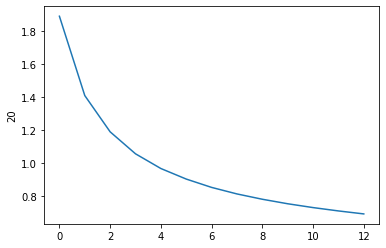

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.ylabel(n_epochs)
plt.show()

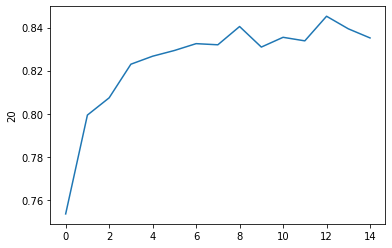

In [ ]:
import matplotlib.pyplot as plt
plt.plot(val_accs)
plt.ylabel(n_epochs)
plt.show()

We then added option lemmas, MLP and weights to balance weights.
The results are seen below 

In [ ]:
classifier_mlp_weights_lemmas = WSDClassifier(num_labels, device = 'cuda', use_mlp = True, hidden_size = 100,nbr_lemmas = len(lemma2i), lemma_embedding_size = 518, add_lemmas = True)

lemmahidden 1286


In [ ]:
#for name, param in classifier.named_parameters():
  #print("PARAM named %s, of shape %s" % (name, str(param.shape)))
  #print(param.requires_grad)

In [ ]:
# training
from statistics import mean
import numpy as np
stop_early = 0
early_stopping_patience = 6

BATCH_SIZE = 32
LR = 0.0005
n_epochs = 30
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight("balanced", np.unique(list(label2i.values())),list(label2i.values()))

class_weight = torch.tensor(class_weight, dtype=torch.float).to(classifier.device)

#loss_function = nn.CrossEntropyLoss()
loss_function = nn.NLLLoss(weight = class_weight) 
#optimizer = optim.SGD(classifier.parameters(), lr=LR)
optimizer = optim.Adam(classifier_mlp_weights_lemmas.parameters(), lr=LR)

config_name = 'sequoiaftb.asfalda_1_3.wsd.lr' + 'Adam' + str(LR) + '_bs' + str(BATCH_SIZE)
out_model_file = './' + config_name + '.model'
out_log_file = './' + config_name + '.log'


# perte à chaque époque (sur le train / sur le validation set)
train_losses = []
val_losses = []
val_accs = []
min_val_loss = None
epoch_losses = []
# pour tests: utiliser training sur dev
#train_data = data['dev'] # data['train']
train_data = wsd_data['train']
val_data = wsd_data['val']
dev_data = wsd_data['dev']

val_accs = []

print('Training.....')
acc = 0
for epoch in range(n_epochs):  # loop over the dataset multiple times
  classifier_mlp_weights_lemmas.train()
  
  print('acc',acc)
  print('Training..... epoch nr: ', epoch)
  for b_tid_seqs, b_tg_trks, b_labels, b_lemma_idx in train_data.make_batches(64, shuffle_data=True):
    
  
    optimizer.zero_grad()
    b_tid_seqs = torch.tensor(b_tid_seqs, device=classifier_mlp_weights_lemmas.device).to(classifier_mlp_weights_lemmas.device)
    b_tg_trks = torch.tensor(b_tg_trks, device=classifier_mlp_weights_lemmas.device).to(classifier_mlp_weights_lemmas.device)
    b_labels = torch.tensor(b_labels, device=classifier_mlp_weights_lemmas.device).to(classifier_mlp_weights_lemmas.device)
    b_lemma_idx = torch.tensor(b_lemma_idx, device=classifier_mlp_weights_lemmas.device).to(classifier_mlp_weights_lemmas.device)
    log_probs = classifier_mlp_weights_lemmas(b_tid_seqs, b_tg_trks, b_lemma_idx).to(classifier_mlp_weights_lemmas.device)
  
    loss = loss_function(log_probs,  b_labels)
    
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
  epoch_losses.append(sum(train_losses)/len(train_losses))
 
  pred_labels, val_losses, val_acc, _, _ = classifier_mlp_weights_lemmas.run_on_dataset(val_data, optimizer, batch_size=32, validation_use=True)
  val_accs.append(val_acc)
  print('--------')
  print('train loss: ',epoch_losses[-1],'val accuracy: ', val_acc)
  print('--------')
 
  if val_acc>=acc:
    acc=val_acc
  else:
    early_stopping_patience +=1
    if early_stopping_patience == stop_early:
      print('Stopping early...')
      break

  
    
  
 


        
  
           
# TODO HERE
# training
# - basic : train for NB_EPOCHS +
# - BONUS : early stopping: stop epoch loop as soon as accuracy on dev decreases+

# don't forget to toggle 
# - classifier.train() when training on train
# - classifier.eval() when evaluating on val corpus


print("train losses: %s" % ' / '.join([ "%.4f" % x for x in epoch_losses]))
print("val   losses: %s" % ' / '.join([ "%.4f" % x for x in val_losses]))



Training.....
acc 0
Training..... epoch nr:  0
--------
train loss:  2.427831932619044 val accuracy:  0.6674905838041432
--------
acc 0.6674905838041432
Training..... epoch nr:  1
--------
train loss:  1.9151406714218198 val accuracy:  0.750882768361582
--------
acc 0.750882768361582
Training..... epoch nr:  2
--------
train loss:  1.634779173158421 val accuracy:  0.7776012241054614
--------
acc 0.7776012241054614
Training..... epoch nr:  3
--------
train loss:  1.4515471636342459 val accuracy:  0.7937853107344632
--------
acc 0.7937853107344632
Training..... epoch nr:  4
--------
train loss:  1.3227205254959062 val accuracy:  0.8052024482109228
--------
acc 0.8052024482109228
Training..... epoch nr:  5
--------
train loss:  1.225951257805105 val accuracy:  0.813382768361582
--------
acc 0.813382768361582
Training..... epoch nr:  6
--------
train loss:  1.1484279026161517 val accuracy:  0.8211511299435028
--------
acc 0.8211511299435028
Training..... epoch nr:  7
--------
train loss:  

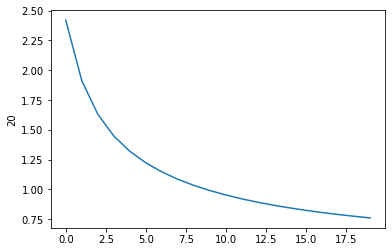

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.ylabel(n_epochs)
plt.show()

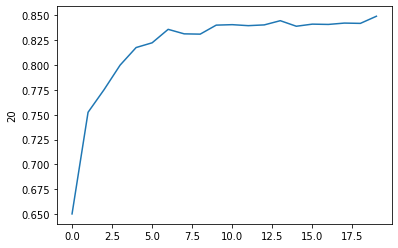

In [ ]:
import matplotlib.pyplot as plt
plt.plot(val_accs)
plt.ylabel(n_epochs)
plt.show()

Below is a variant of classifier using class weight and MLP layer but NOT lemmas

In [ ]:
classifier_mlp_weights = WSDClassifier(num_labels, device = 'cuda', use_mlp = True, hidden_size = 100,nbr_lemmas = len(lemma2i), lemma_embedding_size = 518, add_lemmas = False)

In [ ]:
# training
from statistics import mean
import numpy as np
stop_early = 0
early_stopping_patience = 6

BATCH_SIZE = 32
LR = 0.0005
n_epochs = 25
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight("balanced", np.unique(list(label2i.values())),list(label2i.values()))

class_weight = torch.tensor(class_weight, dtype=torch.float).to(classifier.device)

#loss_function = nn.CrossEntropyLoss()
loss_function = nn.NLLLoss(weight = class_weight) 
#optimizer = optim.SGD(classifier_mlp_weights.parameters(), lr=LR)
optimizer = optim.Adam(classifier_mlp_weights.parameters(), lr=LR)

config_name = 'sequoiaftb.asfalda_1_3.wsd.lr' + 'Adam' + str(LR) + '_bs' + str(BATCH_SIZE)
out_model_file = './' + config_name + '.model'
out_log_file = './' + config_name + '.log'


# perte à chaque époque (sur le train / sur le validation set)
train_losses = []
val_losses = []
val_accs = []
min_val_loss = None
epoch_losses = []
# pour tests: utiliser training sur dev
#train_data = data['dev'] # data['train']
train_data = wsd_data['train']
val_data = wsd_data['val']
dev_data = wsd_data['dev']
classifier_mlp_weights.train()

print('Training.....')
acc = 0
for epoch in range(n_epochs):  # loop over the dataset multiple times
  classifier_mlp_weights.train()
  
  print('acc',acc)
  print('Training..... epoch nr: ', epoch)
  for b_tid_seqs, b_tg_trks, b_labels, b_lemma_idx in train_data.make_batches(64, shuffle_data=True):
    
  
    optimizer.zero_grad()
    b_tid_seqs = torch.tensor(b_tid_seqs, device=classifier_mlp_weights.device).to(classifier_mlp_weights.device)
    b_tg_trks = torch.tensor(b_tg_trks, device=classifier_mlp_weights.device).to(classifier_mlp_weights.device)
    b_labels = torch.tensor(b_labels, device=classifier_mlp_weights.device).to(classifier_mlp_weights.device)
    b_lemma_idx = torch.tensor(b_lemma_idx, device=classifier_mlp_weights.device).to(classifier_mlp_weights.device)
    log_probs = classifier_mlp_weights(b_tid_seqs, b_tg_trks, b_lemma_idx).to(classifier_mlp_weights.device)
  
    loss = loss_function(log_probs,  b_labels)
    
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
  epoch_losses.append(sum(train_losses)/len(train_losses))
  
  pred_labels, val_losses, val_acc, _, _ =classifier_mlp_weights.run_on_dataset(val_data, optimizer, batch_size=32, validation_use=True)
  val_accs.append(val_acc)
  print('--------')
  print('train loss: ',epoch_losses[-1],'val accuracy: ', val_acc)
  print('--------')
 
  if val_acc>=acc:
    acc=val_acc
  else:
    early_stopping_patience +=1
    if early_stopping_patience == stop_early:
      print('Stopping early...')
      break

  
    
  
 


        
  
           
# TODO HERE
# training
# - basic : train for NB_EPOCHS +
# - BONUS : early stopping: stop epoch loop as soon as accuracy on dev decreases+

# don't forget to toggle 
# - classifier.train() when training on train
# - classifier.eval() when evaluating on val corpus


print("train losses: %s" % ' / '.join([ "%.4f" % x for x in epoch_losses]))
print("val   losses: %s" % ' / '.join([ "%.4f" % x for x in val_losses]))



Training.....
acc 0
Training..... epoch nr:  0
--------
train loss:  2.4700915464430255 val accuracy:  0.6634887005649718
--------
acc 0.6634887005649718
Training..... epoch nr:  1
--------
train loss:  1.9382467915803308 val accuracy:  0.7461158192090396
--------
acc 0.7461158192090396
Training..... epoch nr:  2
--------
train loss:  1.6437570344661427 val accuracy:  0.781367702448211
--------
acc 0.781367702448211
Training..... epoch nr:  3
--------
train loss:  1.4556877709670213 val accuracy:  0.7986111111111112
--------
acc 0.7986111111111112
Training..... epoch nr:  4
--------
train loss:  1.3212100524866082 val accuracy:  0.7996704331450094
--------
acc 0.7996704331450094
Training..... epoch nr:  5
--------
train loss:  1.2209217516075068 val accuracy:  0.821680790960452
--------
acc 0.821680790960452
Training..... epoch nr:  6
--------
train loss:  1.141903290681901 val accuracy:  0.8264477401129944
--------
acc 0.8264477401129944
Training..... epoch nr:  7
--------
train loss:

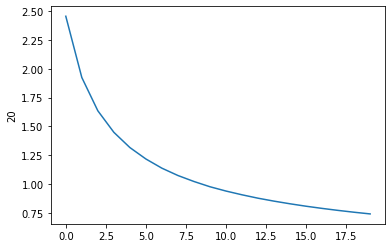

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.ylabel(n_epochs)
plt.show()

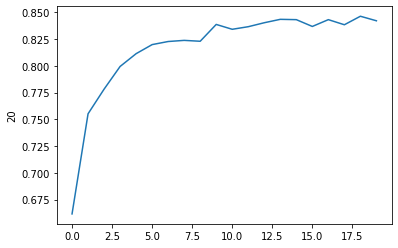

In [ ]:
import matplotlib.pyplot as plt
plt.plot(val_accs)
plt.ylabel(n_epochs)
plt.show()

### Evaluation

In [ ]:
test_data = wsd_data['test']

**Normal version of classifier**

In [ ]:
# TODO HERE : run on dev and evaluate
pred_labels, val_losses, dev_acc, b_labels, _ = classifier.run_on_dataset(dev_data, optimizer, batch_size=32, validation_use=False)
pred_labels, val_losses, test_acc, b_labels, _ = classifier.run_on_dataset(test_data, optimizer, batch_size=32, validation_use=False)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
print('dev acc: ', dev_acc, 'test acc:', test_acc)

dev acc:  0.8452380952380952 test acc: 0.8507070249597424


**Classifier with mlp, lemmas and weights**

In [ ]:
pred_labels, val_losses, dev_acc1, b_labels, _ = classifier_mlp_weights_lemmas.run_on_dataset(dev_data, optimizer, batch_size=32, validation_use=False)
pred_labels, val_losses, test_acc1, b_labels, _ = classifier_mlp_weights_lemmas.run_on_dataset(test_data, optimizer, batch_size=32, validation_use=False)

In [ ]:
print('dev acc: ', dev_acc1, 'test acc:', test_acc1)

dev acc:  0.8571428571428571 test acc: 0.8703829508856683


**Classifier with weights**

In [ ]:
pred_labels, val_losses, dev_acc2, b_labels, _ = classifier_weights.run_on_dataset(dev_data, optimizer, batch_size=32, validation_use=False)
pred_labels, val_losses, test_acc2, b_labels, _ = classifier_weights.run_on_dataset(test_data, optimizer, batch_size=32, validation_use=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
print('dev acc: ', dev_acc2, 'test acc:' , test_acc2)

dev acc:  0.8519345238095238 test acc: 0.8606078904991948


**Classifier mlp and weights**

In [ ]:
pred_labels, val_losses, dev_acc3, b_labels, _ = classifier_mlp_weights.run_on_dataset(dev_data, optimizer, batch_size=32, validation_use=False)
pred_labels, val_losses, test_acc3, b_labels, _ = classifier_mlp_weights.run_on_dataset(test_data, optimizer, batch_size=32, validation_use=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
print('dev acc: ', dev_acc3, 'test acc:', test_acc3)

dev acc:  0.8586309523809523 test acc: 0.862746578099839


**I solved the problem of UserWarning, it's still present in the output cells because I didn't want to retrain everything**

In [ ]:
# BONUS : generalization analysis
#   Do you think it would be better to predict seen-in-train lemma/frame associations only ?
#   (implement analysis of the predictions to answer that question)

# VARIOUS OTHER POSSIBLE BONUSES: does it help to:
# - fine-tune with a MLP instead of single layer ? + ADDED
# - balance classes ("Other_sense" is over represented in dataset) ?+ ADDED
#    Not sure, because natural distribution of data is a precious clue (cf. MFS)
# - add a lemma embedding of the target ? - nn_embeddings ? + ADDED
# - use the average of the target subword tokens instead of the first one only ?
# ... other ideas are welcome ...
#ADDED also early stopping 


#@@ Très bien pour les bonus